In [54]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from tqdm import tqdm
import argparse

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.utils import save_image


# import the autoencoder
from autoencoder import Autoencoder
from solver import *
from receptive_field import get_RF_linear

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load model

In [55]:
modelpath = '/home/david/sparsify_models/AE/MNIST/2024-09-19_21-24-20/'
plotpath = '/home/david/sparsify_plots/RF/'
if not os.path.exists(plotpath):
    os.makedirs(plotpath)

In [56]:
## define the model
n_input = 28*28#32*32*3
n_layers = 3
n_hidden_ls = [512,256,32]

sae = Autoencoder(n_input,n_hidden_ls,n_layers)
dae = Autoencoder(n_input,n_hidden_ls,n_layers)

In [57]:
sae_weights = torch.load(modelpath + 'Static/model_weights_epoch9.pth')
sae.load_state_dict(sae_weights)

dae_weights = torch.load(modelpath + 'Dev/cell_division/model_weights_epoch9.pth')
dae.load_state_dict(dae_weights)

/tmp/ipykernel_18469/1056518654.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae_weights = torch.load(modelpath + 'Static/model_weights_epoch9.pth')
/tmp/ipykernel_18

<All keys matched successfully>

## Load data

In [58]:
# load dataset
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

print('Number of CIFAR10 train images: {}'.format(len(trainset)))
print('Number of CIFAR10 test images: {}'.format(len(testset)))

Number of CIFAR10 train images: 60000
Number of CIFAR10 test images: 10000


In [59]:
batch_size = 128
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=6)


## Linear Receptive field

In [60]:
rf_sae = get_RF_linear(sae, testset)
print(rf_sae.shape)

torch.Size([32, 784])


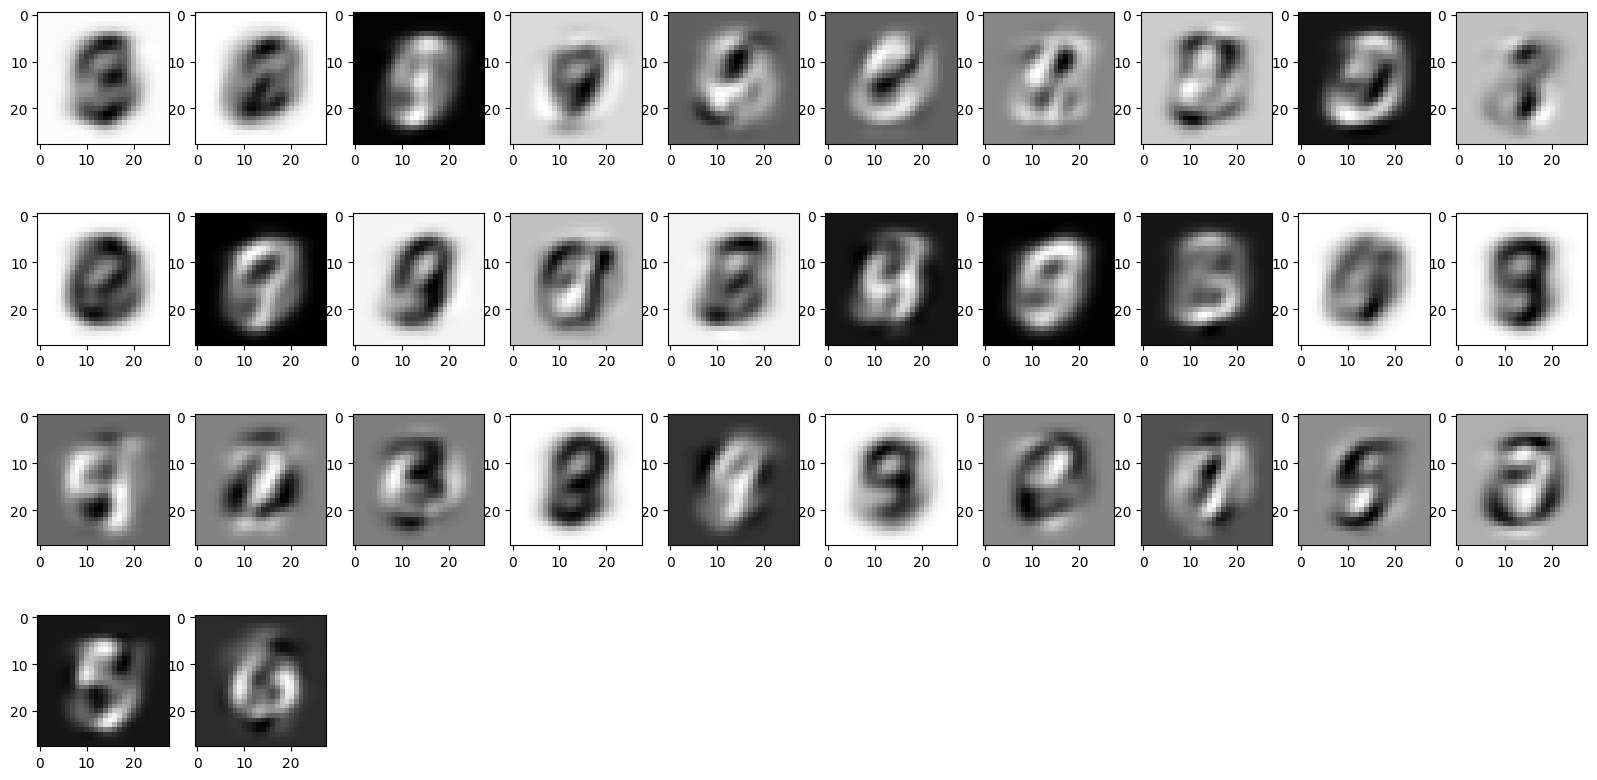

In [61]:
fig = plt.figure(figsize=(20,10))

for i,rf in enumerate(rf_sae):
    plt.subplot(4,10,i+1)
    plt.imshow(rf.reshape(28,28),cmap='binary_r')

plt.savefig(plotpath + 'sae_linear.pdf',bbox_inches='tight')

In [62]:
rf_dae = get_RF_linear(dae, testset)
print(rf_dae.shape)

torch.Size([32, 784])


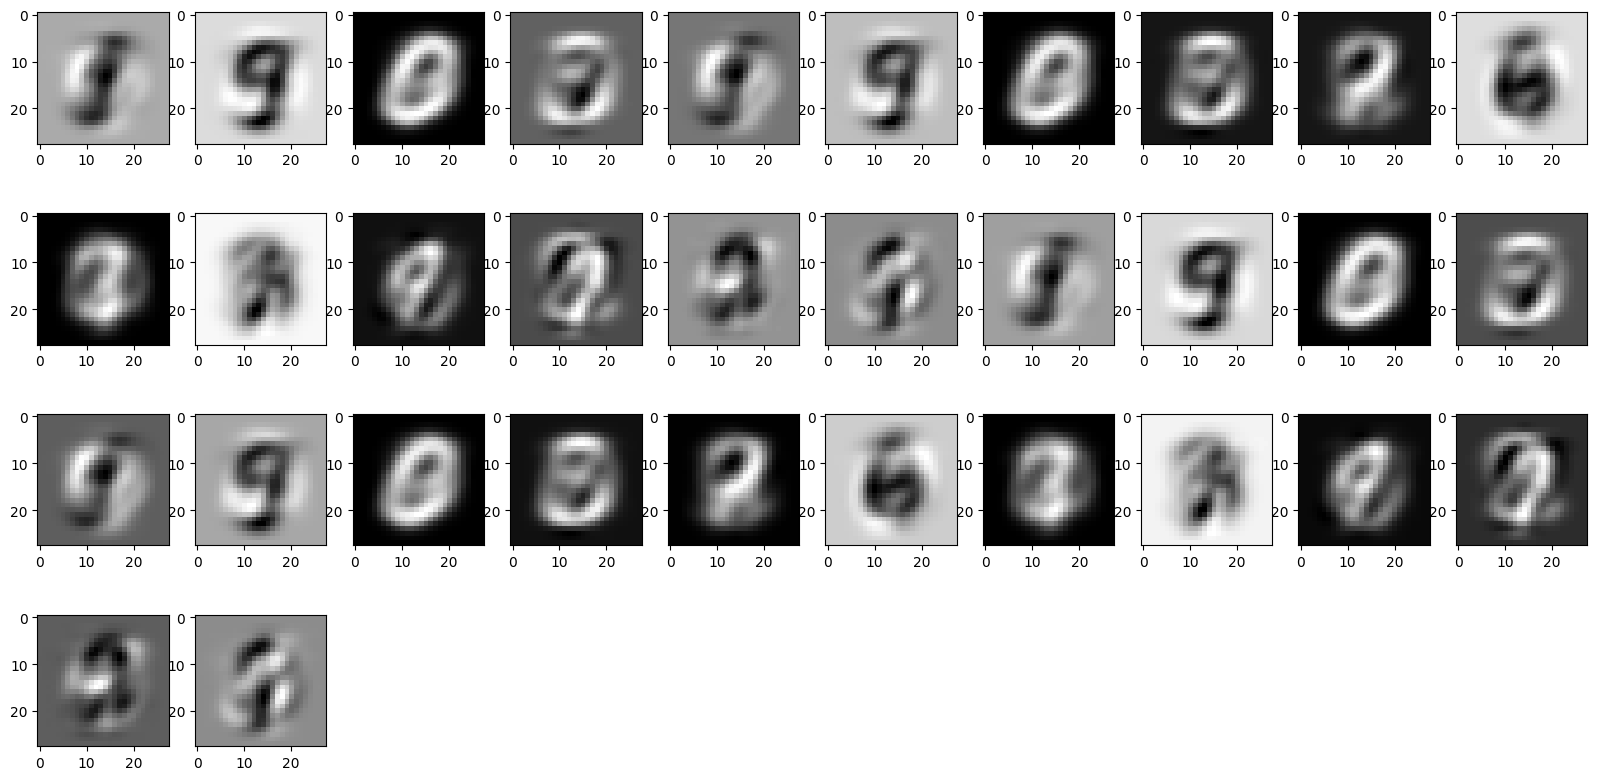

In [63]:
fig = plt.figure(figsize=(20,10))

for i,rf in enumerate(rf_dae):
    plt.subplot(4,10,i+1)
    plt.imshow(rf.reshape(28,28),cmap='binary_r')
plt.savefig(plotpath + 'dae_linear.pdf',bbox_inches='tight')

## Activation maximization

In [64]:
#sys.path.append('/home/kong/Activation-Maximization')
import act_max_util as amu

In [65]:
data = torch.randn(28, 28)
data = data.unsqueeze(0)
input = data.view(data.size(0), -1)
input.requires_grad_(True)

print(input.shape)

torch.Size([1, 784])


In [66]:
activation_dictionary = {}
layer_name = 'bottle_neck'

sae.encoder.encoder_3.register_forward_hook(amu.layer_hook(activation_dictionary, layer_name))

In [67]:
steps = 100                 # perform 100 iterations
unit = 0                 # flamingo class of Imagenet
alpha = torch.tensor(100)   # learning rate (step size) 
verbose = False              # print activation every step
L2_Decay = True             # enable L2 decay regularizer
Gaussian_Blur = False        # enable Gaussian regularizer
Norm_Crop = False            # enable norm regularizer
Contrib_Crop = False         # enable contribution regularizer

In [68]:
sae_rf_ls = []
for i in range(32):
    output = amu.act_max(network=sae,
                    input=input,
                    layer_activation=activation_dictionary,
                    layer_name=layer_name,
                    unit=i,
                    steps=steps,
                    alpha=alpha,
                    verbose=verbose,
                    L2_Decay=L2_Decay,
                    Gaussian_Blur=Gaussian_Blur,
                    Norm_Crop=Norm_Crop,
                    Contrib_Crop=Contrib_Crop,
                    )
    sae_rf_ls.append(output.detach().numpy())

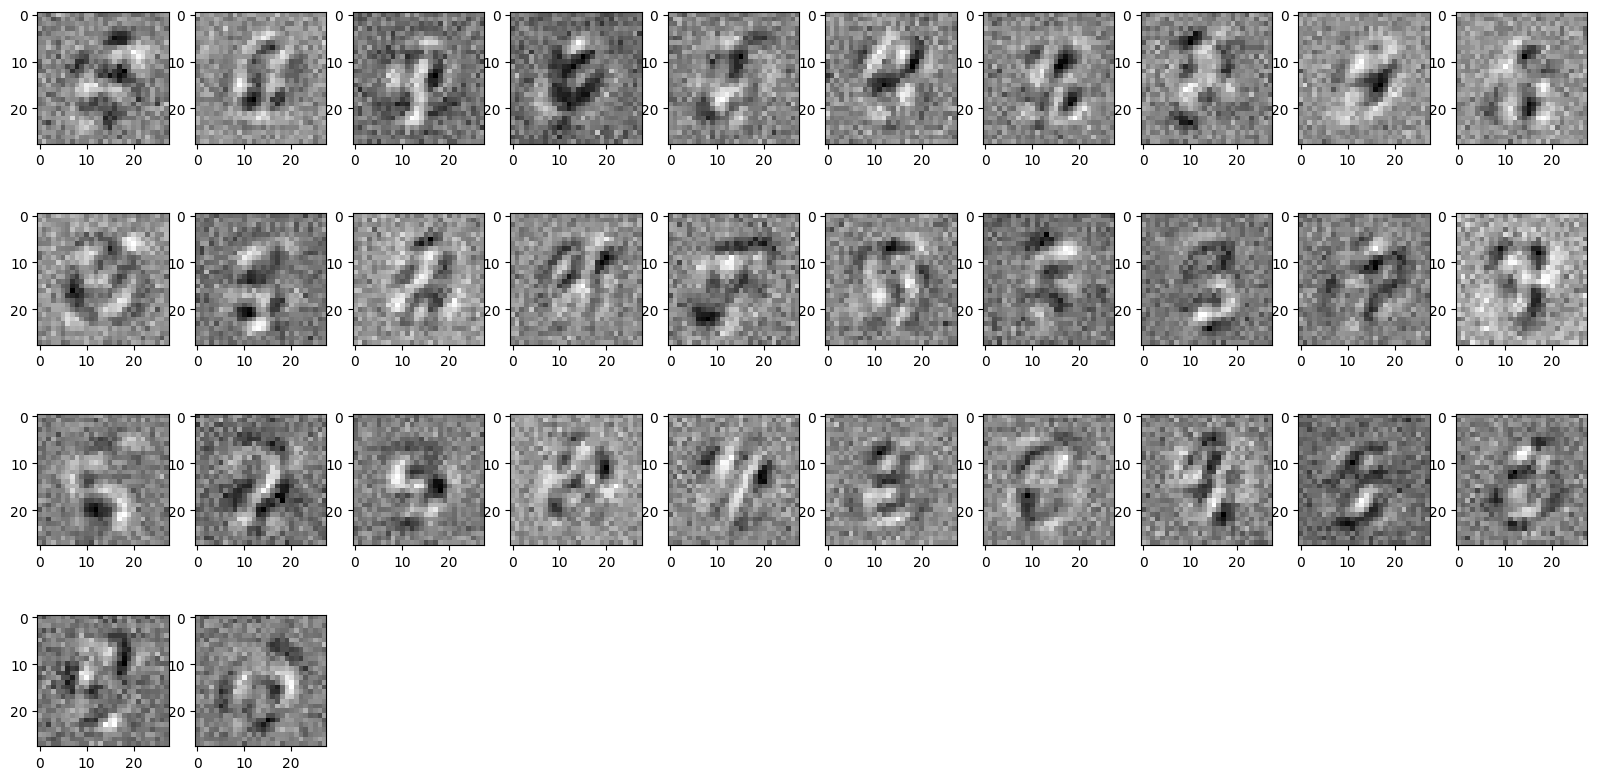

In [69]:
fig = plt.figure(figsize=(20,10))
for i in range(32):
    plt.subplot(4,10,i+1)
    plt.imshow(sae_rf_ls[i].reshape(28,28),cmap='binary_r')
plt.savefig(plotpath + 'sae_maxact.pdf',bbox_inches='tight')

In [70]:
activation_dictionary = {}
layer_name = 'bottle_neck'

dae.encoder.encoder_3.register_forward_hook(amu.layer_hook(activation_dictionary, layer_name))

In [71]:
dae_rf_ls = []
for i in range(32):
    output = amu.act_max(network=dae,
                    input=input,
                    layer_activation=activation_dictionary,
                    layer_name=layer_name,
                    unit=i,
                    steps=steps,
                    alpha=alpha,
                    verbose=verbose,
                    L2_Decay=L2_Decay,
                    Gaussian_Blur=Gaussian_Blur,
                    Norm_Crop=Norm_Crop,
                    Contrib_Crop=Contrib_Crop,
                    )
    dae_rf_ls.append(output.detach().numpy())

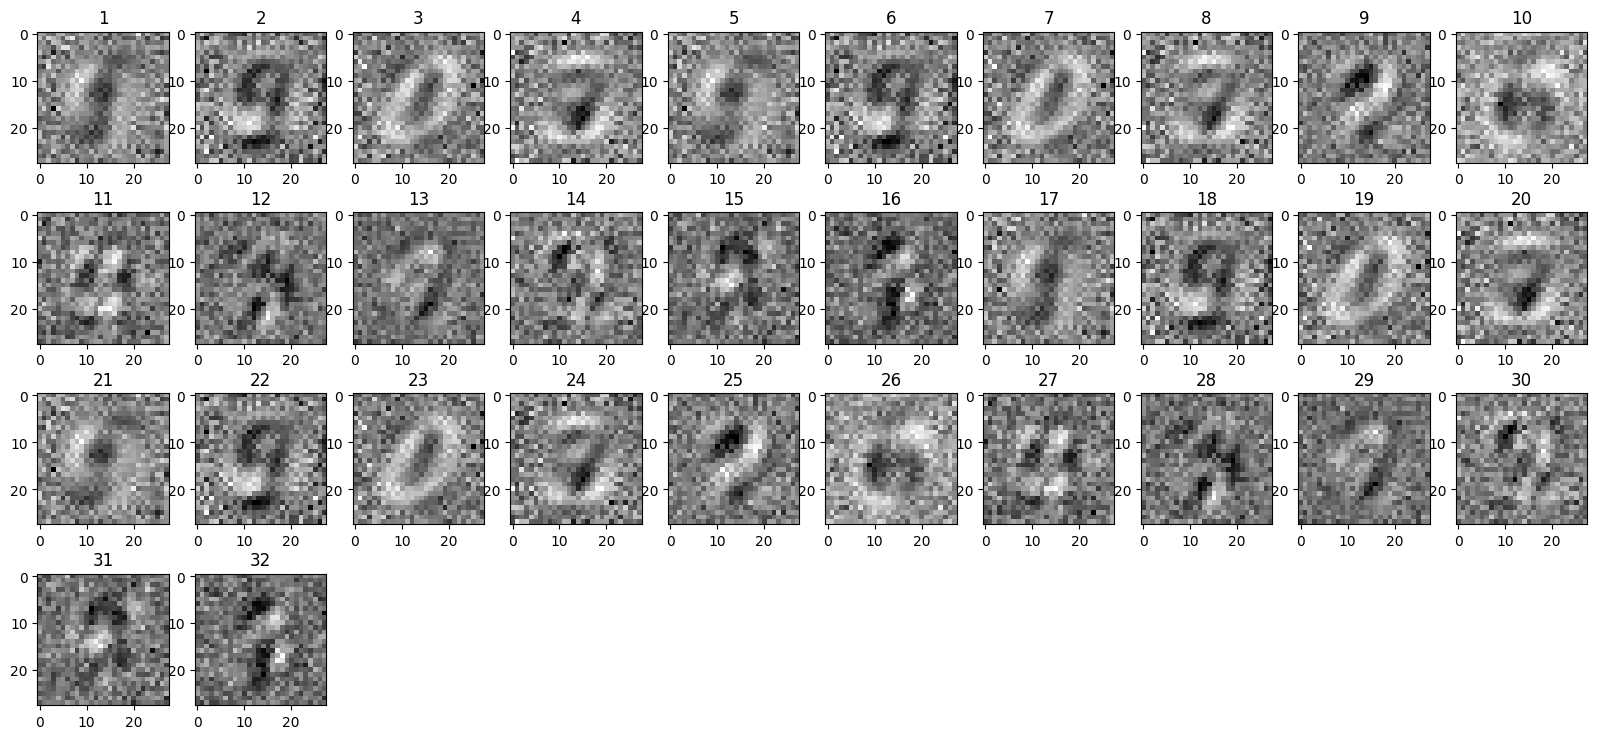

In [72]:
fig = plt.figure(figsize=(20,9))
for i in range(32):
    plt.subplot(4,10,i+1)
    plt.title(str(i+1))
    plt.imshow(dae_rf_ls[i].reshape(28,28),cmap='binary_r')
plt.savefig(plotpath + 'dae_maxact.pdf',bbox_inches='tight')

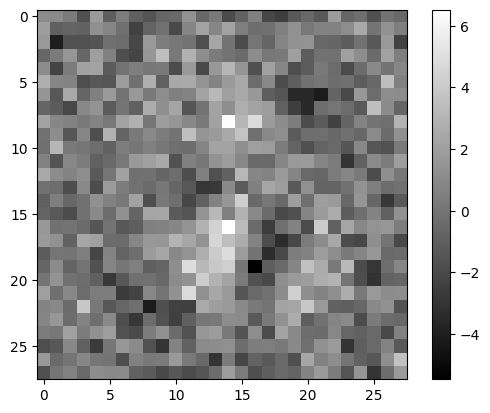

In [73]:
diff = dae_rf_ls[4] - dae_rf_ls[0]
plt.imshow(diff.reshape(28,28),cmap='binary_r')
plt.colorbar()